In [3]:
import pandas as pd
import os
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [6]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
import py7zr

In [7]:
train = pd.read_csv('/Users/HP/Downloads/kkbox-music-recommendation-challenge/train.csv',nrows = 100000)
extra_song = pd.read_csv('/Users/HP/Downloads/kkbox-music-recommendation-challenge/song_extra_info.csv')
members = pd.read_csv('/Users/HP/Downloads/kkbox-music-recommendation-challenge/members.csv')
songs = pd.read_csv('/Users/HP/Downloads/kkbox-music-recommendation-challenge/songs.csv')

In [8]:
print("train: ",train.shape)
print("Extra songs: ",extra_song.shape)
print("members: ",members.shape)
print("songs: ",songs.shape)

train:  (100000, 6)
Extra songs:  (2295971, 3)
members:  (34403, 7)
songs:  (2296320, 7)


In [9]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [10]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [11]:
extra_song.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [12]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [13]:
merge1 = pd.merge(train, songs, on = 'song_id', how = 'left')
merge2 = pd.merge(merge1, extra_song, on = 'song_id', how = 'left')
music = pd.merge(merge2, members, on = 'msno', how = 'left')
del train, songs, extra_song, members, merge1, merge2
music.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [14]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

In [15]:
 music.shape

(100000, 20)

In [16]:
music.isnull().sum()

msno                          0
song_id                       0
source_system_tab           303
source_screen_name         4273
source_type                 195
target                        0
song_length                   4
genre_ids                  1502
artist_name                   4
composer                  21472
lyricist                  40691
language                      4
name                          9
isrc                       8525
city                          0
bd                            0
gender                    38672
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [17]:
# registration_init_time
music.registration_init_time = pd.to_datetime(music.registration_init_time, format='%Y%m%d', errors='ignore')
music['registration_init_time_year'] = music['registration_init_time'].dt.year
music['registration_init_time_month'] = music['registration_init_time'].dt.month
music['registration_init_time_day'] = music['registration_init_time'].dt.day

# expiration_date
music.expiration_date = pd.to_datetime(music.expiration_date,  format='%Y%m%d', errors='ignore')
music['expiration_date_year'] = music['expiration_date'].dt.year
music['expiration_date_month'] = music['expiration_date'].dt.month
music['expiration_date_day'] = music['expiration_date'].dt.day

In [18]:
music.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [19]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in music.columns :
    music[i] = label_encoder.fit_transform(music[i])

In [20]:
music.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,1647,6022,1,6,5,1,3513,94,424,1615,5743,8,3900,3293,0,1,2,2,1176,328,8,0,1,4,9,4
1,3471,18027,3,7,4,1,8945,28,3757,10068,5743,8,6186,18561,11,14,0,3,974,304,7,4,24,4,8,10
2,3471,9744,3,7,4,1,4972,28,2550,5137,5743,8,4359,21796,11,14,0,3,974,304,7,4,24,4,8,10
3,3471,1868,3,7,4,1,7193,1,3231,4202,5743,0,2685,3322,11,14,0,3,974,304,7,4,24,4,8,10
4,1647,2688,1,6,5,1,2329,0,561,970,5743,8,9286,8761,0,1,2,2,1176,328,8,0,1,4,9,4


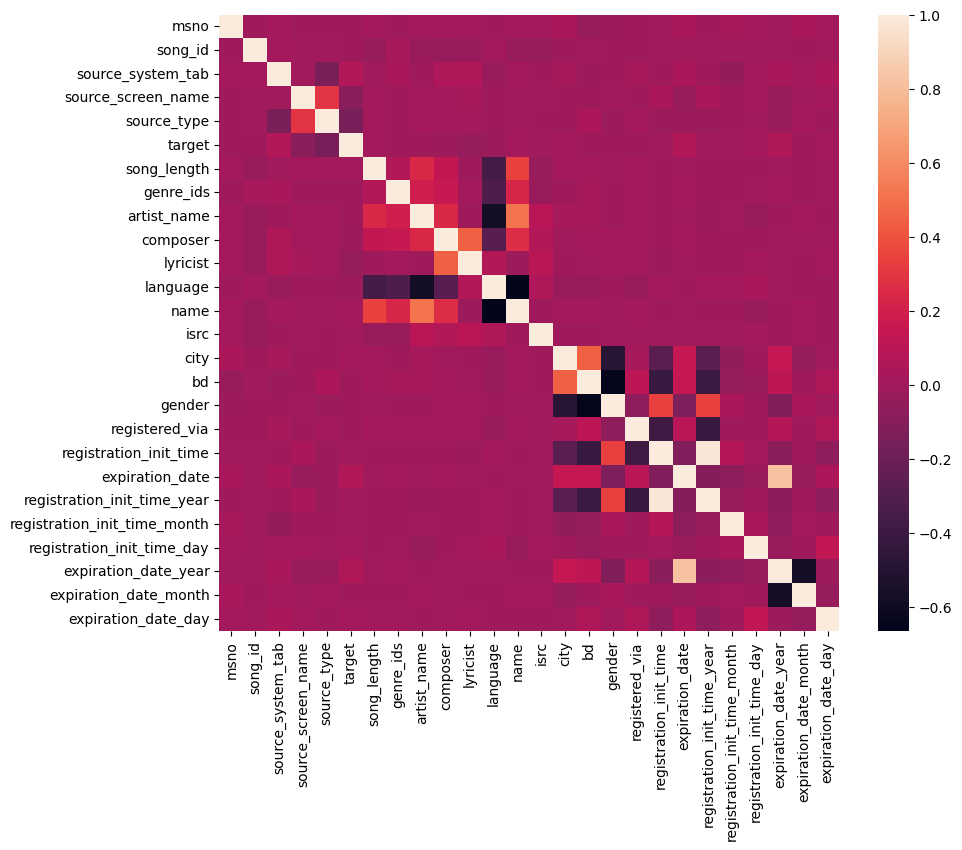

In [21]:
#Correlation matrix
plt.figure(figsize=[10,8])
sns.heatmap(music.corr())
plt.show()

In [22]:
music.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [23]:
x = music.drop('target', axis = 1)
y = music['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [26]:
#with classweights
rf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1.0050505050505052, 1: 0.9949494949494948}
)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(classification_report(y_test, pred))
print()
print("Accuracy :", accuracy_score(y_test, pred)*100)
print("ROC :", roc_auc_score(y_test, pred)*100)

              precision    recall  f1-score   support

           0       0.76      0.56      0.65      4967
           1       0.87      0.94      0.90     15033

    accuracy                           0.85     20000
   macro avg       0.82      0.75      0.78     20000
weighted avg       0.84      0.85      0.84     20000


Accuracy : 84.85000000000001
ROC : 75.30893546847095


In [27]:
# without classweights
rf = RandomForestClassifier(
        n_estimators = 1000
)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(classification_report(y_test, pred))
print()
print("Accuracy :", accuracy_score(y_test, pred)*100)
print("ROC :", roc_auc_score(y_test, pred)*100)

              precision    recall  f1-score   support

           0       0.76      0.56      0.65      4967
           1       0.87      0.94      0.90     15033

    accuracy                           0.85     20000
   macro avg       0.82      0.75      0.78     20000
weighted avg       0.84      0.85      0.84     20000


Accuracy : 84.81
ROC : 75.2823273396876


In [28]:
et = ExtraTreesClassifier(
      n_estimators=1000
)

et.fit(x_train,y_train)
pred = et.predict(x_test)
print(classification_report(y_test, pred))
print()
print("Accuracy :", accuracy_score(y_test, pred)*100)
print("ROC :", roc_auc_score(y_test, pred)*100)

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      4967
           1       0.87      0.93      0.90     15033

    accuracy                           0.85     20000
   macro avg       0.81      0.76      0.78     20000
weighted avg       0.84      0.85      0.84     20000


Accuracy : 84.92
ROC : 76.32612051888636


In [29]:
#without classweights
XGB = xgb.XGBClassifier(
    n_estimators = 1000
)

XGB.fit(x_train,y_train)
pred = XGB.predict(x_test)
print(classification_report(y_test, pred))
print()
print("Accuracy :", accuracy_score(y_test, pred)*100)
print("ROC :", roc_auc_score(y_test, pred)*100)

              precision    recall  f1-score   support

           0       0.73      0.58      0.65      4967
           1       0.87      0.93      0.90     15033

    accuracy                           0.84     20000
   macro avg       0.80      0.76      0.77     20000
weighted avg       0.84      0.84      0.84     20000


Accuracy : 84.395
ROC : 75.6196464416094


In [30]:
cbc = cb.CatBoostClassifier(
    n_estimators = 1000,
    verbose=0
)

cbc.fit(x_train,y_train)
pred = cbc.predict(x_test)
print(classification_report(y_test, pred))
print()
print("Accuracy :", accuracy_score(y_test, pred)*100)
print("ROC :", roc_auc_score(y_test, pred)*100)

              precision    recall  f1-score   support

           0       0.75      0.47      0.58      4967
           1       0.85      0.95      0.89     15033

    accuracy                           0.83     20000
   macro avg       0.80      0.71      0.74     20000
weighted avg       0.82      0.83      0.82     20000


Accuracy : 83.09
ROC : 71.13194941332411


In [31]:
lg = lgbm.LGBMClassifier(
            n_estimators=1000, 
)

lg.fit(x_train,y_train)
pred = lg.predict(x_test)
print(classification_report(y_test, pred))
print()
print("Accuracy :", accuracy_score(y_test, pred)*100)
print("ROC :", roc_auc_score(y_test, pred)*100)

              precision    recall  f1-score   support

           0       0.76      0.54      0.63      4967
           1       0.86      0.94      0.90     15033

    accuracy                           0.84     20000
   macro avg       0.81      0.74      0.77     20000
weighted avg       0.84      0.84      0.83     20000


Accuracy : 84.315
ROC : 74.25204781679486
